# Урок 2. CNN and LSTM for human action recognition

ЗАДАНИЕ 1. Необходимо нормализовать данные в датасете: написать функцию
нормализации и использовать ее внутри класса датасета.

ЗАДАНИЕ 2. Приложен ноутбук в котором генерируется из большого датасета меньшая его
копия. Вам нужно:
a. Сгенерировать меньший датасет из 8-10 классов движения
b. Изменить функцию разбиения датасета на тестовую и тренировочную
часть, увеличив кусок, отводимый на тест
c. Обучить уже существующую модель (предварительно проанализировав
какие параметры нужно менять)
d. Изменить модель для улучшения качества
e. Сгенерировать другой датасет с меньшим количеством “кадром” в нашей
серии и сравнить с улучшилось или ухудшилось качество предсказания.
Провести несколько таких итераций, дать свою оценку уменьшению
кадров, назвать оптимальное, на ваш взгляд, их количество.

In [2]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import pandas as pd

use_cuda = torch.cuda.is_available()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cpu


In [3]:
class LSTM_net(nn.Module):
    def __init__(self,input_dim,hidden_dim,output_dim,layer_num):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim,layer_num,batch_first=True)
#         self.dr = torch.nn.Dropout2d(0.25)
        self.fc = torch.nn.Linear(hidden_dim,output_dim)
        
        
    def forward(self,inputs):
        x = inputs
        lstm_out,(hn,cn) = self.lstm(x)
        out = self.fc(lstm_out[:,-1,:])
        return out

In [4]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def normalize(item):
    for row in item:
        for i in np.arange(len(row)):
            row[i]= sigmoid(row[i])            
    return item    
 

In [5]:
class Skeleton_Dataset(Dataset):
    def __init__(self, file_path, transform=None):
        self.data = pd.read_csv(file_path)
        self.transform = transform


    def __len__(self):
        return len(self.data) 
    
    
    def __getitem__(self, idx):
        item = np.asarray(self.data.iloc[idx,:-1]).reshape(45,75)
        label = self.data.iloc[idx,-1]
        
        if self.transform != None:
            item = self.transform(item)

        return (item, label) 

In [6]:
LABELS = {0: "cheer up", 1: "jump up", 2:  "hand waving", 3: "sitting down", 4: "clapping", 5:'something'}

In [7]:
dataset = Skeleton_Dataset(file_path = "test_01.csv", transform=normalize)

In [8]:
skel, lab = dataset.__getitem__(41)
print(type(skel))
print(LABELS[lab])
print(skel.shape)

<class 'numpy.ndarray'>
something
(45, 75)


In [11]:
[len(dataset),int(0.7*len(dataset)),int(0.3*len(dataset))]

[809, 566, 242]

In [12]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [int(0.7*len(dataset)),int(0.3*len(dataset))+1])
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 16, shuffle=True)

In [13]:
n_hidden = 128
n_joints = 25*3
n_categories = len(LABELS)
n_layer = 2
rnn = LSTM_net(n_joints,n_hidden,n_categories,n_layer)
rnn.to(device)

LSTM_net(
  (lstm): LSTM(75, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)

In [14]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return LABELS[category_i], category_i

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [15]:
sket_tensor = torch.from_numpy(skel).unsqueeze(0).float()
print(sket_tensor.size())
output = rnn(sket_tensor.to(device))
output.topk(5)

torch.Size([1, 45, 75])


torch.return_types.topk(
values=tensor([[ 0.0739,  0.0194,  0.0108,  0.0083, -0.0217]], grad_fn=<TopkBackward>),
indices=tensor([[0, 3, 2, 1, 4]]))

In [16]:
from torch import optim
import time
import math

criterion = nn.CrossEntropyLoss()
learning_rate = 0.0007
optimizer = optim.SGD(rnn.parameters(),lr=learning_rate,momentum=0.9)

all_losses = []
start = time.time()
counter = 0
for epoch in range(800):  
    current_loss = 0
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)
    
        optimizer.zero_grad()
    
        output = rnn(inputs.float())
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step() 


        current_loss += loss.item()
        category = LABELS[int(labels[0])]

        if counter % 500 == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            #####сделать более аккуратный вывод для каждой эпохии
            ######сделать обновление графика loss по ходу обучению  
            print('epoch : %d iter : %d (%s) %.4f  / %s %s' % (epoch, i, timeSince(start), loss, guess, correct))

        
        counter = counter + 1
    if counter % 100 == 0:
        all_losses.append(current_loss / 25)
        current_loss = 0
    

epoch : 0 iter : 0 (0m 0s) 1.7824  / cheer up ✗ (clapping)
epoch : 13 iter : 32 (2m 3s) 1.7871  / hand waving ✗ (cheer up)
epoch : 27 iter : 28 (4m 6s) 1.8070  / hand waving ✗ (something)
epoch : 41 iter : 24 (6m 10s) 1.7777  / hand waving ✗ (jump up)
epoch : 55 iter : 20 (8m 14s) 1.7613  / hand waving ✗ (sitting down)
epoch : 69 iter : 16 (10m 16s) 1.7763  / hand waving ✗ (cheer up)
epoch : 83 iter : 12 (12m 19s) 1.8102  / hand waving ✗ (something)
epoch : 97 iter : 8 (14m 22s) 1.8085  / hand waving ✗ (clapping)
epoch : 111 iter : 4 (16m 25s) 1.7812  / hand waving ✗ (something)
epoch : 125 iter : 0 (18m 27s) 1.7782  / hand waving ✗ (clapping)
epoch : 138 iter : 32 (20m 29s) 1.7040  / cheer up ✓
epoch : 152 iter : 28 (22m 34s) 1.5907  / hand waving ✗ (cheer up)
epoch : 166 iter : 24 (24m 36s) 1.5809  / cheer up ✗ (clapping)
epoch : 180 iter : 20 (26m 39s) 1.3917  / sitting down ✗ (something)
epoch : 194 iter : 16 (28m 44s) 1.2505  / cheer up ✓
epoch : 208 iter : 12 (30m 47s) 1.2717  / 

<IPython.core.display.Javascript object>


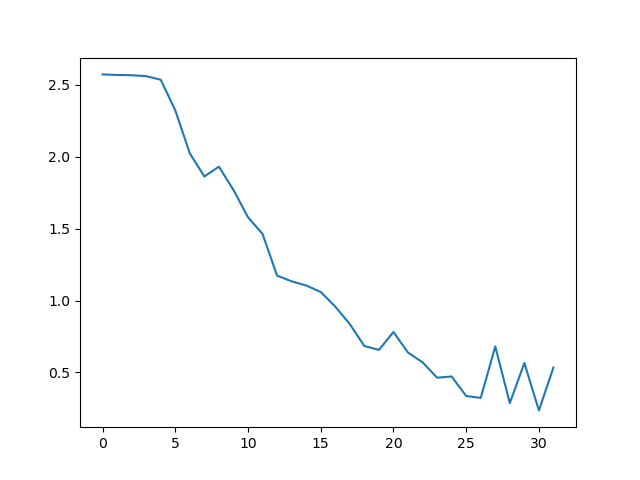

In [22]:
%matplotlib notebook
plt.plot(list(range(0,len(all_losses))),all_losses)
plt.show()

In [25]:
total = 0
right = 0
counter = 0
with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        counter = counter + 1
        inputs, labels = data[0].to(device), data[1].to(device)   
        output = rnn(inputs.float())
        guess, guess_i = categoryFromOutput(output)
        category = LABELS[int(labels[0])]
        
        if guess == category:
            right = right + 1


print('Accuracy of the network:  ',  (100 * right / counter))

Accuracy of the network:   81.25


In [27]:
dataset.data.head(10)

,0,1,2,3,4,5,6,7,8,9,...,3366,3367,3368,3369,3370,3371,3372,3373,3374,labels
0,-0.080141,0.135073,3.691227,-0.058513,0.396866,3.606265,-0.037811,0.652906,3.509790,-0.066903,...,-0.066586,-0.194186,3.880914,0.103227,-0.183070,3.717531,0.180819,-0.130425,3.724300,0
1,-0.035358,0.192430,3.681518,-0.021036,0.422171,3.606487,-0.007186,0.646429,3.520689,-0.042399,...,-0.247820,0.496548,3.406900,-0.056666,0.495373,3.269386,-0.050549,0.490788,3.258667,1
2,0.430001,0.024285,4.098490,0.424111,0.227365,4.005508,0.417157,0.427353,3.902021,0.395301,...,0.098534,0.515498,3.738000,0.243639,0.441711,3.635301,0.292146,0.468907,3.595111,2
3,0.399282,-0.026338,4.099298,0.382165,0.177244,4.002089,0.359935,0.376536,3.893836,0.338453,...,0.300487,0.700893,3.694455,0.535627,0.814146,3.868758,0.530421,0.797046,3.864750,3
4,0.449151,0.001842,4.170505,0.412885,0.192257,4.103466,0.375976,0.379683,4.026225,0.401664,...,0.723439,0.436599,4.077281,0.535588,0.585105,4.202623,0.536817,0.559229,4.186821,3
5,0.424387,0.040135,4.204897,0.398431,0.244353,4.116918,0.373611,0.444495,4.016130,0.355235,...,0.183856,-0.074939,3.937576,0.369532,0.690305,3.718855,0.411135,0.633985,3.657250,4
6,0.284738,0.178680,3.764987,0.299845,0.428857,3.687624,0.314031,0.673921,3.600093,0.296217,...,-0.023884,1.059790,3.376500,0.302396,1.042522,3.275737,0.326857,0.969929,3.259500,5
7,0.259082,0.107407,3.673126,0.252590,0.379644,3.586978,0.246256,0.646283,3.491236,0.249200,...,0.196550,-0.061054,3.691182,0.210572,-0.118589,3.747635,0.195481,-0.115238,3.746909,0
8,0.294459,0.103630,3.653071,0.286122,0.375999,3.580207,0.277820,0.641571,3.499532,0.282940,...,0.426040,0.486630,3.321231,0.428990,0.531056,3.301848,0.384470,0.492621,3.310067,1
9,0.200731,0.208210,3.834275,0.180939,0.461690,3.756772,0.161220,0.709550,3.669313,0.183984,...,0.023829,0.919522,3.430600,0.256620,1.010221,3.579662,0.250573,0.966306,3.661500,2
